In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Animal_Dataset_goat_disease.zip'

# Unzipping the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Check the contents of the dataset
os.listdir('/content/dataset')


['healthy_goat', 'unhealthy_goat']

Directory Setup and Imports
python

In [ ]:
import tensorflow as tf
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Paths to the healthy and unhealthy goat folders
base_dir = '/content/dataset'
healthy_dir = os.path.join(base_dir, 'healthy_goat')
unhealthy_dir = os.path.join(base_dir, 'unhealthy_goat')

print("Healthy Goats:", len(os.listdir(healthy_dir)))
print("Unhealthy Goats:", len(os.listdir(unhealthy_dir)))


Healthy Goats: 446
Unhealthy Goats: 488


Data Preprocessing for CNN

In [ ]:
# Function to check if a file is an image
def is_image(file):
    try:
        Image.open(file).verify()
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

# Filter out non-image files in the dataset
base_dir = '/content/dataset'
for folder in ['healthy_goat', 'unhealthy_goat']:
    folder_path = os.path.join(base_dir, folder)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if not is_image(file_path):
            print(f"Skipping non-image file: {filename}")
            os.remove(file_path)

# Define ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # 20% for validation

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Skipping non-image file: healthy goat_446.jpeg
Found 743 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


Build and Train the CNN Model

In [ ]:
# Define the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 725ms/step - accuracy: 0.5098 - loss: 0.7232 - val_accuracy: 0.5437 - val_loss: 0.6861
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2857 - loss: 0.7284 - val_accuracy: 0.4583 - val_loss: 0.7088
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - accuracy: 0.5716 - loss: 0.6836 - val_accuracy: 0.5250 - val_loss: 0.6871
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5000 - loss: 0.6808 - val_accuracy: 0.5833 - val_loss: 0.6768
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 714ms/step - accuracy: 0.5558 - loss: 0.6784 - val_accuracy: 0.5063 - val_loss: 0.6993
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4688 - loss: 0.7154 - val_accuracy: 0.6667 - val_loss: 0.6467
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 724ms/step - accuracy: 0.5854 - loss: 0.6641 - val_accuracy: 0.6125 - val_loss: 0.6582
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6250 - loss: 0.6512 - val_accuracy: 0.6

Evaluate CNN Model

In [ ]:
# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print(f"Validation Accuracy: {validation_accuracy}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 874ms/step - accuracy: 0.7013 - loss: 0.6078
Validation Accuracy: 0.7228260636329651


Accuracy Plotting

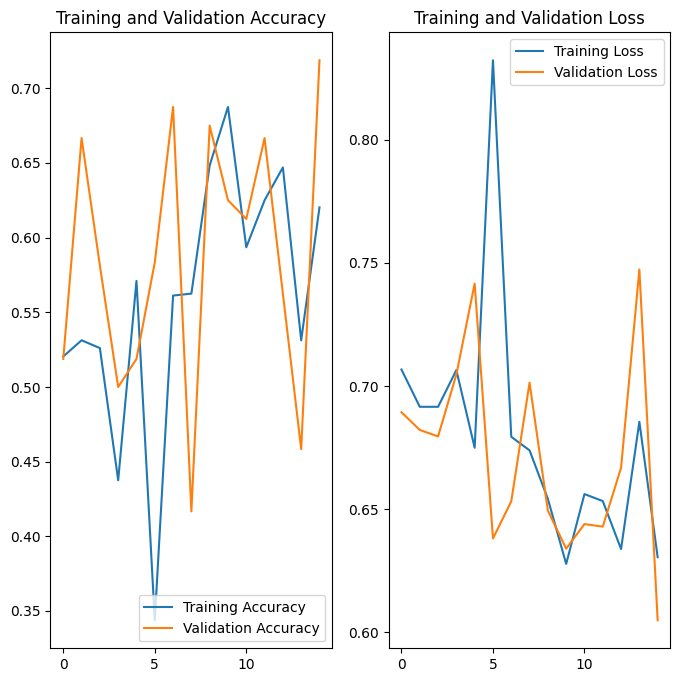

In [ ]:
# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the range to match the number of epochs
epochs_range = range(len(acc))

# Plot accuracy and loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Implement YOLO

In [ ]:
# Install YOLOv5 (if necessary)
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -r requirements.txt  # install


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [ ]:
import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

# Load YOLOv5 model
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')


YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 34.1/78.2 GB disk)


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 180MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


WARNING ⚠️ NMS time limit 0.550s exceeded


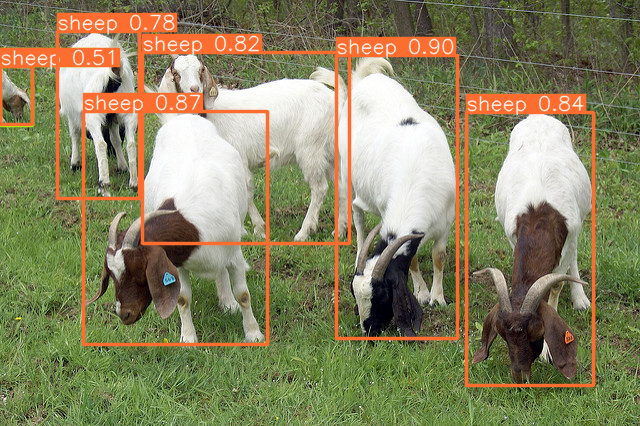

In [ ]:
# Predict with YOLO
img = '/content/dataset/healthy_goat/healthy goat_1.jpeg'  # path to any image to detect
results = model_yolo(img)
results.show()


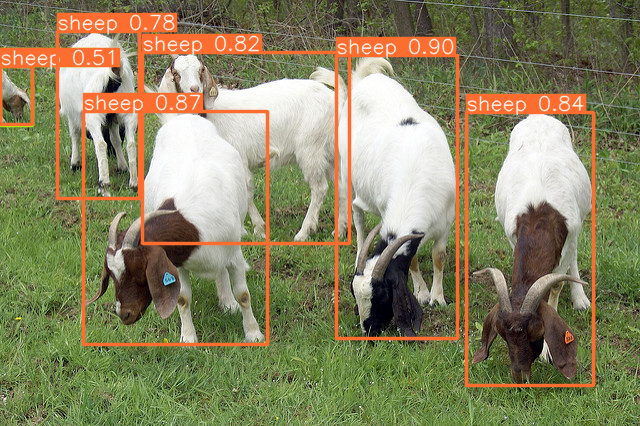

In [ ]:
# run YOLO on images from dataset
test_image_path = '/content/dataset/healthy_goat/healthy goat_1.jpeg'  # replace with a test image from dataset
results = model_yolo(test_image_path)
results.show()

In [ ]:
# Running inference
results = model_yolo(test_image_path)

# Print and save results
results.print()  # Print results (bounding boxes, classes)
results.save()   # Save images with bounding boxes

image 1/1: 426x640 6 sheeps, 1 cow
Speed: 8.6ms pre-process, 9.9ms inference, 2.7ms NMS per image at shape (1, 3, 448, 640)
Saved 1 image to runs/detect/exp


In [ ]:
!pip install pycocotools


In [ ]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def calculate_map(ground_truths, predictions):

    # Create COCO format data structures
    coco_gt = COCO()
    coco_dt = COCO()

    # Define categories (use your actual categories)
    categories = [{'id': 1, 'name': 'class_1'}]  # Example, adjust according to your classes

    # Define images and annotations
    images = [{'id': i, 'width': 640, 'height': 640} for i in range(len(ground_truths))]  # Example dimensions
    coco_gt.dataset = {'images': images, 'annotations': ground_truths, 'categories': categories}
    coco_dt.dataset = {'images': images, 'annotations': predictions, 'categories': categories}

    # Create COCO index
    coco_gt.createIndex()
    coco_dt.createIndex()

    # Evaluate
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats[0]  # mAP

# Example usage
ground_truths = [
    {'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [50, 50, 100, 100], 'area': 10000, 'iscrowd': 0}
]
predictions = [
    {'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [45, 45, 110, 110], 'score': 0.9}
]

yolo_map = calculate_map(ground_truths, predictions)
print(f"YOLO mAP: {yolo_map:.2f}")


creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 

In [ ]:
print("Comparison Summary:")
print(f"1. CNN Validation Accuracy: {validation_accuracy:.2f}")
print(f"2. YOLO Mean Average Precision (mAP): {yolo_map:.2f}")


Comparison Summary:
1. CNN Validation Accuracy: 0.72
2. YOLO Mean Average Precision (mAP): -1.00


In [ ]:
!pip install nbconvert
!jupyter nbconvert --to html /content/Malkya_Dissertation.ipynb

[NbConvertApp] Converting notebook /content/Malkya_Dissertation.ipynb to html
[NbConvertApp] Writing 2279726 bytes to /content/Malkya_Dissertation.html
